# ELEN3007 ICAO-Codes-Weather-analysis

##### This Script imports the weather data for the Chulman Airport (UELL) weather station, in Russia

In [51]:
import numpy as np
import seaborn as sns
import json
import csv
import scipy.stats
import matplotlib.pyplot as plt
from IPython.display import HTML, display

First, define some useful functions

In [76]:
def printMatrix(data): #used to print matricies to HTML
    display(HTML(
        '<table><tr>{}</tr></table>'.format(
            '</tr><tr>'.join(
                '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in data)
            )
    ))
    
def printText(text):
    display(HTML('<p>'+text+'<p>'))

<p>hello<p>

##Question 1 
Import data from text files. These are stored as csvs in the "Data" directory in the repo. This CSV is formatted as: {Unit Timestamp, max Temp, avg Temp, min Temp}. Each CSV is read into a matrix. These matricies are then added to a vector so they can be itterated through later on

In [6]:
w1995 = np.genfromtxt('Data/1995.csv', delimiter=',')
w2000 = np.genfromtxt('Data/2000.csv', delimiter=',')
w2005 = np.genfromtxt('Data/2005.csv', delimiter=',')
w2010 = np.genfromtxt('Data/2010.csv', delimiter=',')
w2015 = np.genfromtxt('Data/2015.csv', delimiter=',')

weatherData=[w1995,w2000,w2005,w2010,w2015]

##Question 2
Next, identify the minimum, maximum, mean and standard deviation for each year. As the matricies are in a vector, we can do this sequentially in a loop. These outputs are produced in a matrix, where the columns are the years (1995,2000,2005,2010,2015) and the rows are the minimum, maximum, mean and standard deviation for each year. This can be seen in the table below:

|Year|1995|2000|2005|2010|2015|
|------|------|------|------|------|------|
|Minimum|------|------|------|------|------|
|Maximum|------|------|------|------|------|
|Mean|------|------|------|------|------|
|Standard Deviation|------|------|------|------|------|


In [54]:
dataValues=np.zeros((4,5))
counter = 0;
for year in weatherData:
    dataValues[0,counter]=year[:,1].max() #max of max values
    dataValues[1,counter]=year[:,3].min() #min of min values
    dataValues[2,counter]=round(year[:,2].mean(), 2) #average of average values
    dataValues[3,counter]=round(year[:,2].std(), 2) #Standard deviation of average values
    counter=counter+1;
printMatrix(dataValues)

29.0,37.0,30.0,28.0,33.0
-45.0,-45.0,-41.0,-45.0,-42.0
-6.65,-6.83,-6.39,-6.83,-5.43
18.01,16.56,17.08,18.1,16.53


##Question 3
Each Years probability distribution functions are now plotted, for each year, on the same set of axes. To achive this, a fixed plot of univariate distributions is generated. This is done with the Seaborn displot function

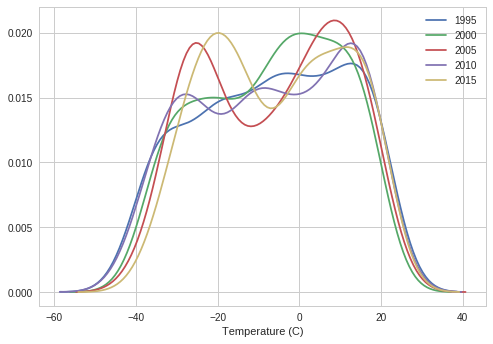

In [41]:
sns.set_style('whitegrid')
counter =0;
for year in weatherData:
    sns.distplot(year[:,2], hist=False,
                 label=1995+counter*5, #count the current year, from the first dataset in 1995
                 axlabel="Temperature (C)")
    counter=counter+1;
plt.show()

##Question 4
The cross-correlation between each year’s annual temperatures is now calculated. This is shown as a matrix output

In [ ]:
for x in range(0,5):
    for y in range(0,5):
        print("Year: {} correlated with year: {}".format(1995+5*x,1995+5*y))
        printMatrix(
            np.corrcoef(weatherData[x][0:365,2],
                        weatherData[y][0:365,2])
                    ) 


Year: 1995 correlated with year: 1995


TypeError: printMatrix() takes 1 positional argument but 2 were given